# Cài đặt môi trường import các package

In [1]:
from google.colab import drive  
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install -q keras-bert==0.85.0
!pip install -q keras-rectified-adam
!pip install keras==2.3.1
%tensorflow_version 1.x

     |████████████████████████████████| 378kB 4.2MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
ERROR: keras-bert 0.85.0 has requirement Keras>=2.4.3, but you'll have keras 2.3.1 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
TensorFlow 1.x selected.


In [11]:
import pickle
import pandas as pd
path = "/content/drive/MyDrive/ML/Sentiment-Analysis-using-BERT/"
import os
os.environ['TF_KERAS'] = '1'
import codecs
import tensorflow as tf
import tensorflow.keras as keras
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
import numpy as np
from keras_bert.layers import Extract
from keras.regularizers import l1

# Tao hệ thống tử điển

Cài đặt và giải nén hệ thống từ điển được lưu sẵn trên google storage.

In [12]:
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


Đọc file *vocab.txt* bao gồm các từ vựng và thứ tự của chúng cũng là mức độ tích cực tăng dần

In [13]:
pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')
token_dict = {}
with codecs.open(vocab_path, 'rb','utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)# the first word is the most negative

from keras_bert import Tokenizer
tokenizer = Tokenizer(token_dict,cased=True)

In [14]:
SEQ_LEN = 256
BATCH_SIZE = 16
EPOCHS = 1
LR = 2e-5

# Load dữ liệu train và dữ liệu test từ file lên

Định nghĩ hàn **load_data** chuyển câu thành vector.

In [15]:
from sklearn.model_selection import train_test_split
def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
      ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
      indices.append(ids)

    return [indices, np.zeros_like(indices)], np.array(sentiments)

Load dữ liệu huấn luyện và kiểm thử từ NTC_SV

In [16]:
df = pd.read_csv(path+"/Data/NTC_SV/NTC_SV_train.csv")
df = df.dropna()
data = df.review.to_list()
label = df.label.to_list()
data_train,data_valid,label_train,label_valid = train_test_split(data,label,test_size=0.15,random_state=48)
X_train,Y_train = load_data(data_train,label_train)
X_valid,Y_valid = load_data(data_valid,label_valid)

In [17]:
test = pd.read_csv(path+'/Data/NTC_SV/NTC_SV_test.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()
X_test,Y_test = load_data(data_test,label_test)

# Khởi tạo model và train

In [18]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    trainable=True,
    seq_len=SEQ_LEN,
    output_layer_num=4
)
inputs = model.inputs[:2]
newout = Extract(index=0)(model.output)
newout = keras.layers.Dense(768,activation='relu')(newout)
outputs = keras.layers.Dense(units=1, activation='sigmoid')(newout)
model = keras.models.Model(inputs, outputs)
model.compile(
  loss='binary_crossentropy',
  optimizer = RAdam(learning_rate=LR),
  metrics=['accuracy'],
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


AttributeError: ignored

In [19]:
from keras.callbacks import ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path+"checkpoint.ckpt",                                            
                                                 verbose=1)
callbacks_list = [checkpoint]

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 256)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 256, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 256, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [21]:
model.load_weights(path+"/Data/Base_weight/lastweight")

In [ ]:
# model.fit(X_train,Y_train,epochs=2,batch_size=16,verbose = 1,validation_data=[X_valid,Y_valid],callbacks=callbacks_list) 
model.fit(X_train,Y_train,epochs=1,batch_size=16,verbose = 1,validation_data=[X_valid,Y_valid])   

Train on 34646 samples, validate on 6114 samples
34646/34646 [==============================] - 2342s 68ms/sample - loss: 0.3455 - acc: 0.8503 - val_loss: 0.2622 - val_acc: 0.8937


# Kiểm thử

In [23]:
def classify_sentiment(list_text):
  sample, _ = load_data(list_text,[])
  probability = model.predict(sample)
  result=[] 
  for i in range(len(list_text)):  
    print(probability)
    if np.round(probability[i])==1:
      result.append("Tích cực")
    else:
      result.append("Tiêu cực")
  return result

In [25]:
print(classify_sentiment(["thức ăn cực kì ngon"]))

[[0.8361433]]
['Tích cực']


In [ ]:
model.save_weights(path+"/Data/OneEpoch/lastweight")

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
y_pred = np.round(model.predict(X_test))
print(precision_score(Y_test,y_pred))
print(recall_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred))

0.8936128907008348
0.9206
0.9069057235740321


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
cn = confusion_matrix(Y_test,y_pred,labels=labels)

In [ ]:
#@title plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()

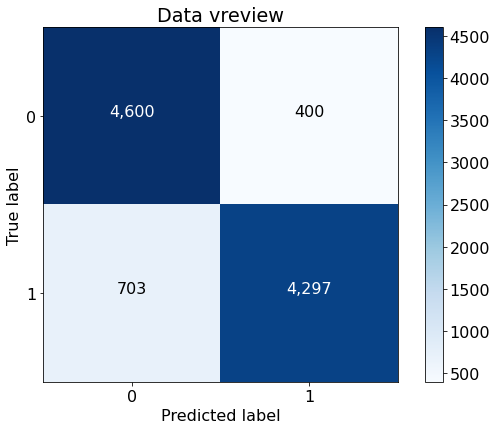

In [ ]:
plot_confusion_matrix(cn,title='Data vreview',normalize=False,target_names=labels,path_file=path+'/Data/Base_weight/bert_base_vreview_cm.svg')

In [ ]:
for i in range(1000):
  if y_pred[i]!=Y_test[i]:
    print(y_pred[i],Y_test[i])
    print(data_test[i])

[0.] 1
điều ấn_tượng positive chính là mùi negative positive bún_bò thơm_lừng trước khi bước vào quán nhân_viên thân_thiện positive gửi xe chu_đáo positive mình gọi tô bún đặc_biệt positive rất ấn_tượng positive về cách trình_bày và tô bún rất quá hớp nước dùng đậm vị huế tô bún đầy thịt nghe cô chủ quán nói là thịt bò nhập từ úc thịt heo đều có kiểm_định chất_lượng positive mình rất an_tâm thịt bò và giò rất mềm positive rau lại tươi positive nhất_là rau_muống mình là rất khó negative về phần này vì đối_với mình rau chính là nhân_vật chính trong tô bún này vì thịt và nước_lèo có ngon positive tới đâu mà rau thì héo úa dai_nhách thì tô bún cũng mất điểm với những điều này thì cũng tuong ứng phù_hợp positive với giá tiền hơn là những ly trà phúc long hay saobucks chẳng bổ béo gì
[1.] 0
mới mở_cửa mà mấy đứa trực từ vào ngồi chờ cho đỡ nắng nữa đi đúng positive đợt khuyến_mãi nên rẻ positive nữa keke cơ_mà không phải vị nào cũng ngon positive bạn mình ăn vị có màu mint mà không phải mint